# Using "machine learning" to approximate a 3rd degree polynomial in 5D Space

In this notebook, we will:
- Generate a synthetic 3rd degree polynomial signal in a 5D input space.
- Plot the true signal along with noisy observations (including a few outliers).
- Build a pipeline that normalizes data, applies PCA (dimentionality reduction), and performs polynomial regression with regularization.
- Illustrate overfitting by using an excessively high polynomial degree.
- Use k-fold cross-validation with grid search to select the best polynomial degree and regularization penalty.
- Fit the final model and evaluate it on a test set.

<i>(To make it simple, we are also using a polynomial to approximate the function - sorry, it's not **really** machine learning...)</i>

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

## Generate the synthetic data

We create a dataset with a few samples ($X$):
- The first feature, ($x_1$), is in the range ($[-1, 1]$).
- The true signal ($y$) is given by:
  
$$
  y = 2x_1^3 - 3x_1^2 + x_1 + 5 + 0.1x_2 + 0.04x_3^2 
$$
  
- We add Gaussian noise and a few large outliers.
- The final input ($X$) is 5-dimensional: the first column is ($x_1$), and the other 4 columns are not as important.


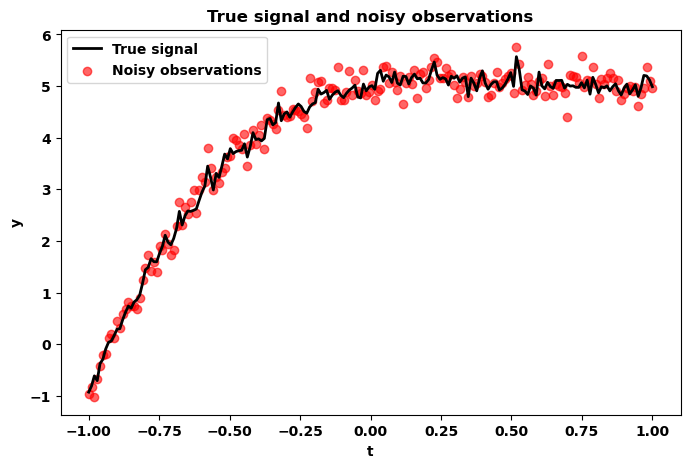

In [111]:
# Number of samples and features
n_samples = 200
n_features = 5

# Generate X values and create the true signal
t = np.linspace(-1, 1, n_samples)
X = np.column_stack((t, np.random.randn(n_samples, n_features)))

def true_signal(X):
    return 2 * X[:, 0]**3 - 3 * X[:, 0]**2 + X[:, 0] + 5 + 0.1*X[:, 1] + 0.05* X[:, 2]**2
y_true = true_signal(X) 

# Generate noise and create y (observations)
noise_scale = 0.2
noise = np.random.normal(scale=noise_scale, size=n_samples)
y_noisy = y_true + noise

# Inject a few outliers
n_outliers = 0
outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
y_noisy[outlier_indices] += np.random.choice([5, -5], size=n_outliers)

# Plot the true signal and the noisy data points (against t)
plt.figure(figsize=(8, 5))
plt.plot(t, y_true, label='True signal', color='black', linewidth=2)
plt.scatter(t, y_noisy, label='Noisy observations', color='red', alpha=0.6)
plt.xlabel('t')
plt.ylabel('y')
plt.title('True signal and noisy observations')
plt.legend()
plt.show()

## Build a pipeline & illustrate overfitting

We create a pipeline that:
- **Normalizes** the data.
- Applies **PCA** to reduce the dimensionality from 5D to 3D.
- Generates polynomial features.
- Uses **L2 regularization** for regression.

To illustrate overfitting, we intentionally set the polynomial degree too high (e.g. degree=15) and observe how the model fits the training data.

You may test the following to improve the situation:
- Less PCA components.
- lower polynomial degree.
- higher alpha (stronger regularization).


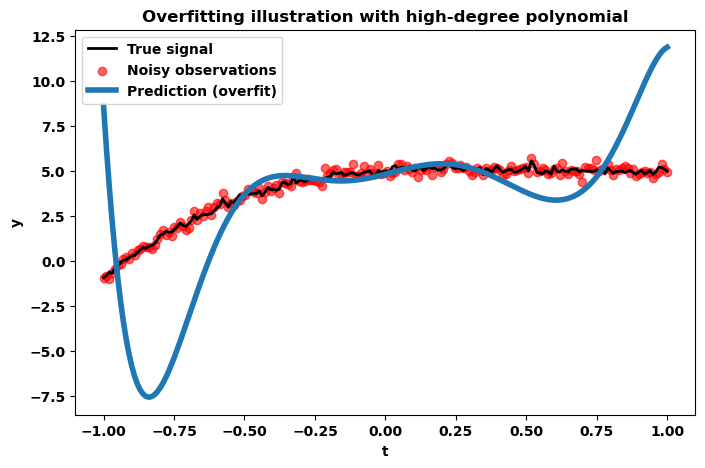

In [112]:
# Create a pipeline with an excessively high polynomial degree (10) to illustrate overfitting
overfit_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('poly', PolynomialFeatures(degree=10, include_bias=True)),
    ('regularization', Ridge(alpha=0.0001))
])

# Fit the pipeline on the training data
overfit_pipeline.fit(X, y_noisy)

# Generate predictions on the training t values (we need to build the corresponding 5D X)
# For visualization, we'll only vary t and use random noise for the other features (set them to zero)
X_vis = np.column_stack((t, np.zeros((n_samples, n_features))))
y_pred_overfit = overfit_pipeline.predict(X_vis)

# Plot the overfitted model prediction
plt.figure(figsize=(8, 5))
plt.plot(t, y_true, label='True signal', color='black', linewidth=2)
plt.scatter(t, y_noisy, label='Noisy observations', color='red', alpha=0.6)
plt.plot(t, y_pred_overfit, label='Prediction (overfit)', linewidth=4)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Overfitting illustration with high-degree polynomial')
plt.legend()
plt.show()


## Hyperparameter tuning with grid search

Now we perform a grid search with k-fold cross-validation to tune:
- The number of PCA components (dimensionality).
- The polynomial degree.
- The regularization penalty (alpha).

We use only a few combinations to keep the grid search fast.


In [113]:
# Create a pipeline (using placeholders for hyperparameters to be tuned)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('poly', PolynomialFeatures(include_bias=True)),
    ('regularization', Ridge())
])

# Define the parameter grid for tuning
param_grid = {
    'pca__n_components': [2, 3, 4, 5], # Try different dimensionalities
    'poly__degree': [3, 4, 5],        # Try degrees around the true 3rd degree signal
    'regularization__alpha': [0.01, 1.0, 10.0, 100.0]   # Different regularization strengths
}

# Set up k-fold cross-validation
cv = KFold(n_splits=4, shuffle=True, random_state=42)

# Create and run the GridSearchCV (MAE scoring is used)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search.fit(X, y_noisy)


# Get the retrained best estimator
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)


Best parameters found:
{'pca__n_components': 5, 'poly__degree': 3, 'regularization__alpha': 10.0}


## Evaluate on extrapolated test data

We now take the best model from the grid search and:
- Fit it on the full training data.
- Generate a test dataset with $X$ values that slightly extrapolate the training range (e.g., $[-1.2, 1.2]$).
- Plot the true signal, the trainind data, and the model predictions.


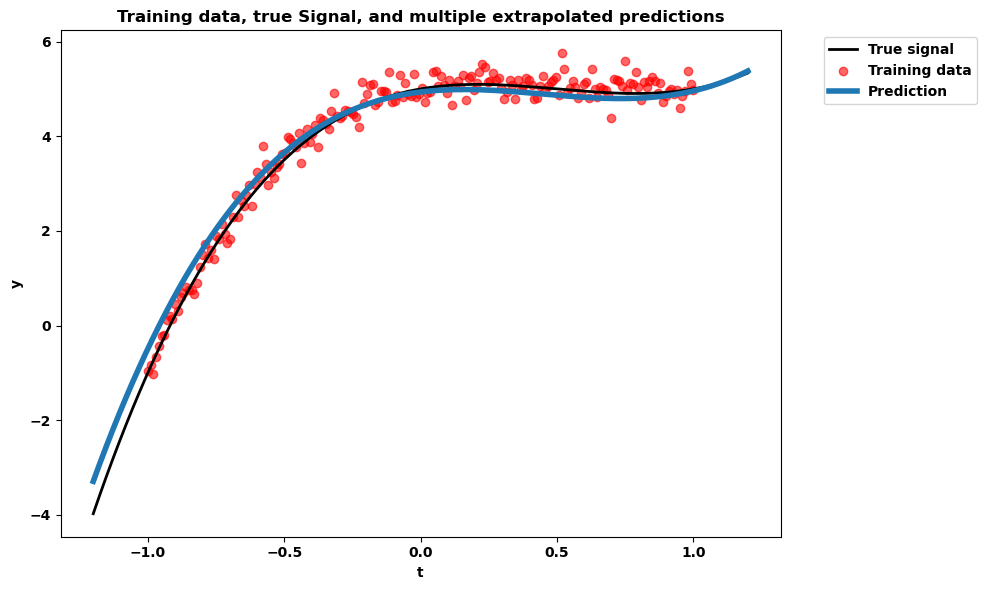

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Generate an extrapolated grid for t
t_extrap = np.linspace(-1.2, 1.2, n_samples)
X_extrap = np.column_stack((t_extrap, 0*np.random.randn(n_samples, n_features)))


# Compute the true signal on the extrapolated grid
y_true_extrap = true_signal(X_extrap) 

# Generate multiple predictions due to noise in the extra dimensions.
# We'll generate, for example, 10 prediction curves.
n_predictions = 10
predictions = []

y_pred = best_model.predict(X_extrap)

# Plot the true signal, training data, and multiple predicted signals.
plt.figure(figsize=(10, 6))
# Plot the true signal line (extrapolated)
plt.plot(t_extrap, y_true_extrap, label="True signal", color="black", linewidth=2)
# Plot the original training data (from previous generation)
plt.scatter(t, y_noisy, label="Training data", color="red", alpha=0.6)
# Plot the predicted curve
plt.plot(t_extrap, y_pred, label="Prediction", linewidth=4)

plt.xlabel('t')
plt.ylabel('y')
plt.title('Training data, true Signal, and multiple extrapolated predictions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
